In [12]:
# Running or Importing .py Files with Google Colab
# Run these codes first in order to install the necessary libraries and 
# perform authorization.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [13]:
!ls

drive  pwfts_taiex_partitioning.csv  sample_data  TAIEX.csv.bz2


In [14]:
!ls "drive/My Drive/education/engenharia UFMG/UFMG MESTRADO PAULO C/CÓDIGOS/pyFTS_PC"

benchmarks.db	   benchmarks.db-wal  pyFTS_COLAB.ipynb  README.md
benchmarks.db-shm  fts_all_v1.ipynb   pyfts.ipynb


In [0]:
import os
os.chdir("drive/My Drive/education/engenharia UFMG/UFMG MESTRADO PAULO C/CÓDIGOS/pyFTS_PC")

In [16]:
!ls

benchmarks.db	   fts_all_v1.ipynb		 pyfts.ipynb
benchmarks.db-shm  pwfts_taiex_partitioning.csv  README.md
benchmarks.db-wal  pyFTS_COLAB.ipynb		 TAIEX.csv.bz2


## Environment Setup

### Library install/update

In [1]:
!pip install -U git+https://github.com/petroniocandido/pyFTS
  
!pip install bokeh

  Cloning https://github.com/petroniocandido/pyFTS to /tmp/pip-req-build-_nq46s44
  Running setup.py bdist_wheel for pyFTS ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-dmi1xvzr/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS
    100% |████████████████████████████████| 16.1MB 2.9MB/s 
  Running setup.py bdist_wheel for bokeh ... - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/04/dc/69/0fe79e7fa6a44f344d5be532011ff43a362ed60060d82589be
Successfully built bokeh


### External libraries import

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Common pyFTS imports and defaults

In [0]:
from pyFTS.common import Util as cUtil
from pyFTS.benchmarks import benchmarks as bchmk

from pyFTS.models import pwfts

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

## Dataset

### Data Loading

In [0]:
from pyFTS.data import TAIEX

dataset = TAIEX.get_data()
dataset_diff = tdiff.apply(dataset)

train_split = 2000
test_length = 200


### Plots

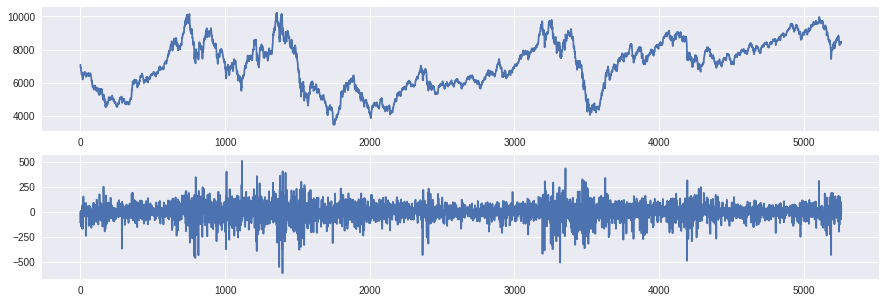

In [5]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,5])
ax[0].plot(dataset)
ax[1].plot(dataset_diff)

cUtil.show_and_save_image(fig,"taiex",False)

### Statistics

In [6]:
result = adfuller(dataset)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.656728
p-value: 0.081830
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [7]:
result = adfuller(dataset_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.392285
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


## Partitioning

### Common imports

In [0]:
from pyFTS.partitioners import Grid, Util as pUtil

### Partitioning optimization

In [0]:
dat = bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2, methods=[pwfts.ProbabilisticWeightedFTS],
                                benchmark_models=False, orders=[1,2,3], partitions=np.arange(10,100,5),
                                progress=False, type='point',
                                #distributed=True, nodes=['192.168.0.102','192.168.0.106','192.168.0.110'],
                                save=True, file="pwfts_taiex_partitioning.csv")

In [10]:
#dat = pd.read_csv("pwfts_taiex_partitioning.csv", sep=";")

from pyFTS.benchmarks import Util as bUtil

dat = bUtil.analytic_tabular_dataframe(dat)

df = dat[dat.Measure == 'RMSE']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Order'], df['Partitions'], df['Value'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

AttributeError: ignored

In [0]:
dat = pd.read_csv("pwfts_taiex_partitioning.csv", sep=";")

### Default partitioners

In [0]:
partitioner = Grid.GridPartitioner(data=dataset[:train_split], npart=30)
partitioner_diff = Grid.GridPartitioner(data=dataset[:train_split], npart=10, transformation=tdiff)

### Plots

In [0]:

pUtil.plot_partitioners(dataset[:train_split], [partitioner,partitioner_diff], tam=[15,7])

## Model Training

### Without transformations 

In [0]:
from pyFTS.common import fts,tree
from pyFTS.models import hofts, pwfts

pfts1_taiex = pwfts.ProbabilisticWeightedFTS("1", partitioner=partitioner)
pfts1_taiex.fit(dataset[:train_split], save_model=True, file_path='pwfts')
pfts1_taiex.shortname = "1st Order"
print(pfts1_taiex)

In [0]:
from bokeh.io import output_notebook, show
output_notebook()

In [0]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

labels = sorted(pfts1_taiex.flrgs.keys(), key=lambda x: pfts1_taiex.sets[x].centroid)
probs = [pfts1_taiex.flrg_lhs_unconditional_probability(pfts1_taiex.flrgs[k]) for k in labels]

ds = ColumnDataSource(data={'x':labels, 'y': probs})


p = figure(plot_width=80, plot_height=30, title="Mean MPG by # Cylinders and Manufacturer",
           toolbar_location=None, tools="")

#p.vbar(x='x', top='y', width=1, source=ds)

show(p)

### With transformations 

In [0]:
from pyFTS.models import pwfts

pfts1_taiex_diff = pwfts.ProbabilisticWeightedFTS("1", partitioner=partitioner_diff)
pfts1_taiex_diff.append_transformation(tdiff)
pfts1_taiex_diff.fit(dataset[:train_split], save_model=True, file_path='pwfts_diff')
pfts1_taiex_diff.shortname = "Diff"
print(pfts1_taiex_diff)

## Probabilistic Forecasting

### One step ahead, without transformations 

In [0]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution')
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=1')
tmp[20].plot(ax[0][1], title='t=20')
tmp[40].plot(ax[0][2], title='t=40')
tmp[60].plot(ax[0][3], title='t=60')
tmp[80].plot(ax[1][0], title='t=80')
tmp[100].plot(ax[1][1], title='t=100')
tmp[120].plot(ax[1][2], title='t=120')
tmp[140].plot(ax[1][3], title='t=140')
tmp[160].plot(ax[2][0], title='t=160')
tmp[180].plot(ax[2][1], title='t=180')
tmp[199].plot(ax[2][2], title='t=200')

In [0]:
from pyFTS.benchmarks import benchmarks as bchmk


plt.rc('text', usetex=False)

tmp1 = []
tmp2 = []
for dist in tmp:
    tmp1.append( dist.quantile([.05, .95]))
    tmp2.append( dist.quantile([.25, .75]))

f, ax = plt.subplots(1, 1, figsize=[20,5])

ax.plot(np.arange(0,200), dataset[train_split:train_split+200], color="black", label='TAIEX')

bchmk.plot_distribution(ax, "Blues", tmp, f, 0)

mi, ma = bchmk.plot_interval(ax, tmp1, 0, color='purple', label="(.05, .95) quantiles")
bchmk.plot_interval(ax, tmp2, 0, color='red', label="(.25, .75) quantiles")

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, without transformations 

In [0]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution', steps_ahead=20)
f, ax = plt.subplots(2, 6, figsize=[20,10])
tmp[0].plot(ax[0][0], title='t=0')
tmp[2].plot(ax[0][1], title='t=2')
tmp[4].plot(ax[0][2], title='t=4')
tmp[6].plot(ax[0][3], title='t=6')
tmp[8].plot(ax[0][4], title='t=8')
tmp[10].plot(ax[0][5], title='t=10')
tmp[10].plot(ax[1][0], title='t=10')
tmp[12].plot(ax[1][1], title='t=12')
tmp[14].plot(ax[1][2], title='t=14')
tmp[16].plot(ax[1][3], title='t=16')
tmp[18].plot(ax[1][4], title='t=18')
tmp[20].plot(ax[1][5], title='t=20')

In [0]:
from pyFTS.benchmarks import benchmarks as bchmk


plt.rc('text', usetex=False)

tmp1 = []
tmp2 = []
for dist in tmp:
    tmp1.append( dist.quantile([.05, .95]))
    tmp2.append( dist.quantile([.25, .75]))

f, ax = plt.subplots(1, 1, figsize=[20,5])

ax.plot(np.arange(0,21), dataset[train_split:train_split+21], color="black", label='TAIEX')

bchmk.plot_distribution(ax, "Blues", tmp, f, 0)

mi, ma = bchmk.plot_interval(ax, tmp1, 0, color='purple', label="(.05, .95) quantiles")
bchmk.plot_interval(ax, tmp2, 0, color='red', label="(.25, .75) quantiles")

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### One step ahead, with transformations 

In [0]:
#pfts1_taiex_diff = Util.load_obj('pwfts_diff')
tmp = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='distribution')
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=1')
tmp[20].plot(ax[0][1], title='t=20')
tmp[40].plot(ax[0][2], title='t=40')
tmp[60].plot(ax[0][3], title='t=60')
tmp[80].plot(ax[1][0], title='t=80')
tmp[100].plot(ax[1][1], title='t=100')
tmp[120].plot(ax[1][2], title='t=120')
tmp[140].plot(ax[1][3], title='t=140')
tmp[160].plot(ax[2][0], title='t=160')
tmp[180].plot(ax[2][1], title='t=180')
tmp[199].plot(ax[2][2], title='t=200')

In [0]:
from pyFTS.benchmarks import benchmarks as bchmk


plt.rc('text', usetex=False)

test = dataset[train_split:train_split+200]

tmp1 = []
tmp2 = []
for ct, dist in enumerate(tmp):
    tmp1.append( test[ct] + dist.quantile([.05, .95]))
    tmp2.append( test[ct] + dist.quantile([.25, .75]))

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,200), dataset[train_split:train_split+200], color="black", label="TAIEX")

bchmk.plot_distribution(ax, "Blues", tmp, f, 0, reference_data=test)

mi, ma = bchmk.plot_interval(ax, tmp1, 0, color='purple', label="(.05, .95) quantiles")
bchmk.plot_interval(ax, tmp2, 0, color='red', label="(.25, .75) quantiles")

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, with transformations 

In [0]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='distribution', steps_ahead=20)
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=0')
tmp[2].plot(ax[0][1], title='t=2')
tmp[4].plot(ax[0][2], title='t=4')
tmp[6].plot(ax[0][3], title='t=6')
tmp[8].plot(ax[1][0], title='t=8')
tmp[10].plot(ax[1][1], title='t=10')
tmp[12].plot(ax[1][2], title='t=12')
tmp[14].plot(ax[1][3], title='t=14')
tmp[16].plot(ax[2][0], title='t=16')
tmp[18].plot(ax[2][1], title='t=18')
tmp[20].plot(ax[2][2], title='t=20')

In [0]:
from pyFTS.benchmarks import benchmarks as bchmk


plt.rc('text', usetex=False)

test = dataset[train_split:train_split+200]

tmp1 = []
tmp2 = []
for ct, dist in enumerate(tmp):
    tmp1.append( test[ct] + dist.quantile([.05, .95]))
    tmp2.append( test[ct] + dist.quantile([.25, .75]))

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), test[:20], color="black", label="TAIEX")

bchmk.plot_distribution(ax, "Blues", tmp, f, 0, reference_data=test)

mi, ma = bchmk.plot_interval(ax, tmp1, 0, color='purple', label="(.05, .95) quantiles")
bchmk.plot_interval(ax, tmp2, 0, color='red', label="(.25, .75) quantiles")

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

## Interval Forecasting

### One step ahead, without transformations 

In [0]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='heuristic')
tmpq = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='quantile', 
                           alpha=.05)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,200), dataset[train_split:train_split+200], color="black", label="TAIEX")

mi, ma = bchmk.plot_interval(ax, tmpe, 0, color='purple', label="Heuristic")
mi, ma = bchmk.plot_interval(ax, tmpq, 0, color='red', label="(.05, .95) quantiles")

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, without transformations 

In [0]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='heuristic',
                          steps_ahead=20)
tmpq = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='quantile', 
                           alpha=.05, steps_ahead=20)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), dataset[train_split:train_split+20], color="black", label="TAIEX")

mi1, ma1 = bchmk.plot_interval(ax, tmpe, 0, color='purple', label="Heuristic")
mi2, ma2 = bchmk.plot_interval(ax, tmpq, 0, color='red', label="(.05, .95) quantiles")

ax.set_ylim([min(mi1,mi2)*0.9, max(ma1,ma2)*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### One step ahead, with transformations 

In [0]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='interval', method='heuristic')
tmpq = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='interval', method='quantile', 
                           alpha=.05)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,200), dataset[train_split:train_split+200], color="black", label="TAIEX")

mi1, ma1 = bchmk.plot_interval(ax, tmpe, 0, color='purple', label="Heuristic")
mi2, ma2 = bchmk.plot_interval(ax, tmpq, 0, color='red', label="(.05, .95) quantiles")

ax.set_ylim([min(mi1,mi2)*0.9, max(ma1,ma2)*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, withtransformations 

In [0]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='interval', method='heuristic',
                          steps_ahead=20)
tmpq = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='interval', method='quantile', 
                           alpha=.05, steps_ahead=20)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), dataset[train_split:train_split+20], color="black", label="TAIEX")

mi1, ma1 = bchmk.plot_interval(ax, tmpe, 0, color='purple', label="Heuristic")
mi2, ma2 = bchmk.plot_interval(ax, tmpq, 0, color='red', label="(.05, .95) quantiles")

ax.set_ylim([min(mi1,mi2)*0.9, max(ma1,ma2)*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

## Point Forecasting

### One step ahead, without transformations 

In [0]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='heuristic')
tmpq = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='expected_value')

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,200), dataset[train_split:train_split+200], color="black", label="TAIEX")


ax.plot(tmpe, color='purple', label="Heuristic")
ax.plot(tmpq, color='red', label="Expected value")

#ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, without transformations 

In [0]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='heuristic',
                          steps_ahead=20)
tmpq = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='expected_value',
                          steps_ahead=20)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), dataset[train_split:train_split+20], color="black", label="TAIEX")


ax.plot(tmpe, color='purple', label="Heuristic")
ax.plot(tmpq, color='red', label="Expected value")

#ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### One step ahead, with transformations 

In [0]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmpe = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='point', method='heuristic',
                          steps_ahead=20)
tmpq = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='point', method='expected_value',
                          steps_ahead=20)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), dataset[train_split:train_split+20], color="black", label="TAIEX")


ax.plot(tmpe, color='purple', label="Heuristic")
ax.plot(tmpq, color='red', label="Expected value")

#ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### Multiple steps ahead, with transformations 

## Benchmarks

In [0]:
bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2, methods=[pwfts.ProbabilisticWeightedFTS],
                                benchmark_models=False, orders=[1,2,3], partitions=np.arange(10,100,5),
                                progress=False, type='point',
                                #steps_ahead=[1,4,7,10], steps_ahead_sampler=10,
                                distributed=True, nodes=['192.168.0.102','192.168.0.106','192.168.0.110'],
                                save=True, file="pwfts_taiex_partitioning.csv")

In [11]:
!ls

pwfts_taiex_partitioning.csv  sample_data  TAIEX.csv.bz2
